# 1. What is your research question, hypothesis and assumptions? Is your result significant?


For this I am picking yellow taxi trip records(parquet) file for analysis. It includes information such as pickup time and dropoff time, trip distance and fares. I believe this can be useful for analyzing trends in taxi usage and fare rates. The data I am using for this analysis is 2023 January data.

The research question that I want to ask this dataset is to identify the factors that affect taxi trip fares in New York City. The hypothesis is that the fare amount is primarily influenced by the trip distance, time of the day, day of the week and passenger count. And I assume that the data is a representative sample of all taxi trips in NYC, and there are no biases or errors in the given dataset.To test the hypothesis I am performing a regression analysis on this data, with fare amount as the dependent variable and trip distance, time of day, day of the week and passenger count as independent variables. I would also perform a significance test on the regression coefficients to determine if the results are significant.

In [431]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [397]:
#Load data into pandas data frame
df = pd.read_parquet('yellow_tripdata_2023-01.parquet', engine='fastparquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


### Exploratory data analysis and data preprocessing

In [398]:
#Checking the dimension and basic info of df
print('Shape of the dataframe:', df.shape)
print('Columns in the dataframe:', df.columns)
print('Data types of the columns:\n', df.dtypes)
print('Basic statistical information about the dataframe:\n', df.describe())

Shape of the dataframe: (3066766, 19)
Columns in the dataframe: Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')
Data types of the columns:
 VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_

In [399]:
print('Missing values in the dataframe:\n', df.isnull().sum())

Missing values in the dataframe:
 VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64


One of the variable that I care about is passenger count. I find out that there are 71743 missing values out of 3066766 dataset. I assume that the missing values are missing at random and and the replaced missing values are representative of the NYC population.

In [400]:
mean_pc = df['passenger_count'].mean()
df['passenger_count'].fillna(mean_pc, inplace=True)
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count              0
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64

In [401]:
#Converting time of day and day of the week to categorical variables
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['hour'] = df['hour'].astype('category')
df['day_of_week'] = df['day_of_week'].astype('category')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour,day_of_week
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0,6
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0,6
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0,6
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0,6
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0,6


In [402]:
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds/60

In [403]:
corr_matrix = df.corr()

# Extract the correlation coefficients for the fare_amount column
correlations = corr_matrix['fare_amount']

# Sort the correlations by their absolute values
abs_correlations = correlations.abs().sort_values(ascending=False)

# Print the top 10 variables with the highest absolute correlation values
print(abs_correlations)


C:\Users\Admin\AppData\Local\Temp\ipykernel_8352\1445895614.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


fare_amount              1.000000
total_amount             0.980323
tolls_amount             0.621687
airport_fee              0.604648
tip_amount               0.590152
trip_duration            0.213675
improvement_surcharge    0.187943
congestion_surcharge     0.181825
extra                    0.141711
PULocationID             0.112452
DOLocationID             0.096006
RatecodeID               0.089576
payment_type             0.080802
mta_tax                  0.049732
passenger_count          0.032179
VendorID                 0.031996
trip_distance            0.016340
Name: fare_amount, dtype: float64


The correlation between fare_amount,total_amount,tolls_amount,airport_fee,tip_amount,trip_duration is more. But the correlation between other variables is not that significant.

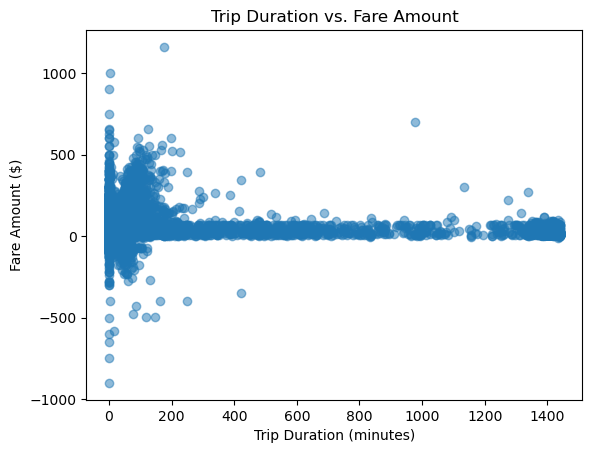

In [404]:
import matplotlib.pyplot as plt

plt.scatter(df['trip_duration'], df['fare_amount'], alpha=0.5)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.title('Trip Duration vs. Fare Amount')
plt.show()


In [405]:
def get_time_category(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'
    
def get_day_category(day):
    if day < 5:
        return 'weekday'
    else:
        return 'weekend'

df['time_of_day'] = df['tpep_pickup_datetime'].apply(lambda x: get_time_category(x.hour))
df['day_category'] = df['tpep_pickup_datetime'].apply(lambda x: get_day_category(x.dayofweek))
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour,day_of_week,trip_duration,time_of_day,day_category
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.0,1.0,14.30,2.5,0.00,0,6,8.433333,night,weekend
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,0.0,1.0,16.90,2.5,0.00,0,6,6.316667,night,weekend
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,0.0,1.0,34.90,2.5,0.00,0,6,12.750000,night,weekend
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,0.0,1.0,20.85,0.0,1.25,0,6,9.616667,night,weekend
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,0.0,1.0,19.68,2.5,0.00,0,6,10.833333,night,weekend


In [406]:
df_encoded = pd.get_dummies(df, columns=['time_of_day', 'day_category'])
df_encoded.drop(['VendorID','tpep_pickup_datetime','tpep_dropoff_datetime', 
                 'RatecodeID', 'store_and_fwd_flag','extra','mta_tax','tip_amount',
                'payment_type', 'tolls_amount', 'improvement_surcharge', 'total_amount',
                'congestion_surcharge', 'airport_fee', 'hour', 'day_of_week'], axis=1, inplace=True)
df_encoded.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'fare_amount', 'trip_duration', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'day_category_weekday', 'day_category_weekend'],
      dtype='object')

In [407]:
df_encoded['PULocationID'].unique()

array([161,  43,  48, 138, 107, 239, 142, 164, 141, 234,  79,  33,  90,
       113, 237, 143, 137, 132, 163,  68, 263, 170, 233, 236, 144, 229,
       249, 162, 224, 151, 211, 148, 238, 231,  13, 262,  75, 264, 125,
       186, 158, 246,  50,   4,  87, 114,  24, 166,  41,  25, 194,  74,
       140, 146,  65, 181, 255, 256,  88, 232, 193, 226,  97, 197,  37,
       189, 261, 225, 244,  45,  40, 116,  80, 209, 243,  60, 265, 100,
        70, 188,  52,   7, 159,  66,  42, 174, 215, 252, 136, 223,  93,
        12,  39, 122, 195,  61, 112, 230,  82, 106, 228, 179, 260, 152,
       121,  49, 198,  83,  17, 168,  56, 119, 145, 129,  36,   1,  95,
        34, 160, 196,  10, 102, 247,  86,  28,  54,  77, 240,  32, 218,
       219, 133,  89, 156, 177,  85, 173,  69,  14,  51, 202, 165, 254,
       235, 127, 131, 191, 157, 130, 182, 241,  11,  62, 258, 169, 123,
        47,   6,  22, 135, 216, 155,  63,  91,  94, 108,  92,  44, 259,
       124,  78, 171, 149,  55, 180,  35,  81, 257, 139,  72,  7

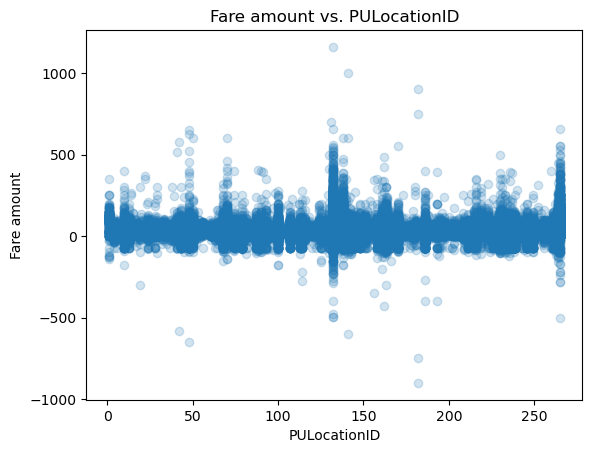

In [408]:
# Plot fare amount vs. time_of_day
plt.scatter(df_encoded['PULocationID'], df_encoded['fare_amount'], alpha=0.2)
plt.xlabel('PULocationID')
plt.ylabel('Fare amount')
plt.title('Fare amount vs. PULocationID')
plt.show()

In [409]:
from scipy.stats import pearsonr

# Calculate the correlation coefficient and p-value between fare amount and hour of the day
corr_coeff, p_value = pearsonr(df_encoded['fare_amount'], df_encoded['day_category_weekday'])

# Print the correlation coefficient and p-value
print(f"Correlation Coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

Correlation Coefficient: -0.002301983199135849
P-value: 5.547411859375183e-05


The correlation coefficient of -0.002 indicates a very weak negative correlation between the fare amount and the day category (weekday or weekend). The p-value of 5.547411859375183e-05 is less than the standard significance level of 0.05, indicating that the correlation is statistically significant. However, the strength of the correlation is so weak that it may not have much practical significance in terms of predicting fare amounts based on the day of the week.

In [410]:
df_encoded.dtypes

passenger_count          float64
trip_distance            float64
PULocationID               int64
DOLocationID               int64
fare_amount              float64
trip_duration            float64
time_of_day_afternoon      uint8
time_of_day_evening        uint8
time_of_day_morning        uint8
time_of_day_night          uint8
day_category_weekday       uint8
day_category_weekend       uint8
dtype: object

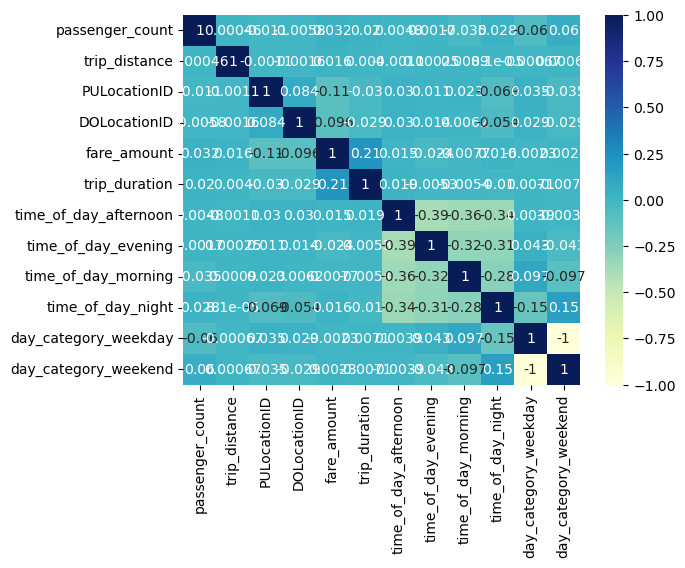

In [411]:
#Checking correlation between the variables
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True)
plt.show()

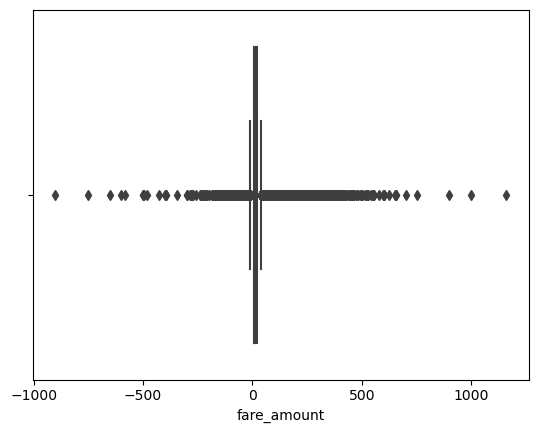

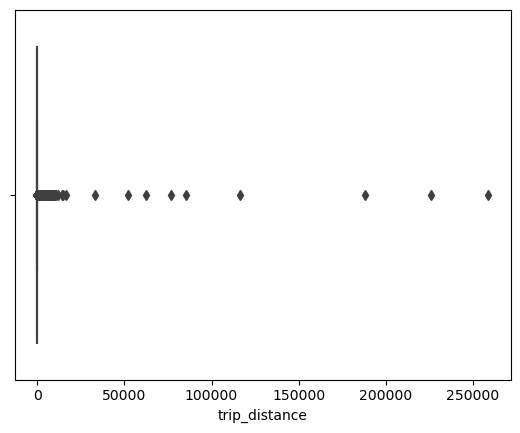

In [412]:
#Checking outliers in the fare amount and trip distance variables
sns.boxplot(x='fare_amount', data=df_encoded)
plt.show()

sns.boxplot(x='trip_distance', data=df_encoded)
plt.show()

In [413]:
#Removing outliers from the dataframe
df_encoded = df_encoded[(df_encoded['fare_amount'] > 2) &
                        (df_encoded['passenger_count'] >= 1) & (df_encoded['passenger_count'] <= 6) &
                        (df_encoded['trip_distance'] > 0) & (df_encoded['trip_distance'] < 100) &
                        (df_encoded['trip_duration'] > 1) & (df_encoded['trip_duration'] < 180)
                       ]
df_encoded.shape               

(2936771, 12)

In [414]:
#sns.pairplot(df_new)

### Regression Analysis

In [415]:
df_encoded.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,trip_duration,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night,day_category_weekday,day_category_weekend
0,1.0,0.97,161,141,9.3,8.433333,0,0,0,1,0,1
1,1.0,1.10,43,237,7.9,6.316667,0,0,0,1,0,1
2,1.0,2.51,48,238,14.9,12.750000,0,0,0,1,0,1
4,1.0,1.43,107,79,11.4,10.833333,0,0,0,1,0,1
5,1.0,1.84,161,137,12.8,12.300000,0,0,0,1,0,1


In [416]:
#Define dependent and independent variables

X = df_encoded.drop(['fare_amount'],axis = 1)
Y = df_encoded['fare_amount']

In [417]:
X.dtypes

passenger_count          float64
trip_distance            float64
PULocationID               int64
DOLocationID               int64
trip_duration            float64
time_of_day_afternoon      uint8
time_of_day_evening        uint8
time_of_day_morning        uint8
time_of_day_night          uint8
day_category_weekday       uint8
day_category_weekend       uint8
dtype: object

In [418]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [419]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [420]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

Coefficients: [ 5.61592862e-02  3.06451296e+00  2.77486271e-04 -1.61054827e-04
  3.09597781e-01  1.70016029e-01 -2.86614924e-02  8.28795732e-02
 -2.24234110e-01 -4.37152495e-03  4.37152495e-03]
Intercept: 3.4111614407426636


In [421]:
Y_pred = model.predict(X_test)
Y_pred

array([ 8.46866177, 13.27615781, 13.68660397, ...,  7.40973364,
        7.42445163,  9.9249503 ])

In [422]:
Y_test

2655202     7.9
2890478    12.1
1577621    13.5
2188079     7.9
403530     14.9
           ... 
1999484    35.2
1023482    12.8
2570408     7.2
1419995     7.9
1638723    10.0
Name: fare_amount, Length: 881032, dtype: float64

### Evaluating the model performance

In [423]:
#Comparing predicted values with real values
r2_score = r2_score(Y_test, Y_pred)
print("R-squared:", r2_score)

R-squared: 0.9444607040739607


The regression model has 9 independent variables (passenger_count, trip_distance, PULocationID, DOLocationID, trip_duration, time_of_day_afternoon, time_of_day_evening, time_of_day_morning, and time_of_day_night) and one dependent variable (fare_amount).
An R-squared value of 0.9444607040739607 indicates that 94.4% of the variability in the dependent variable (y) can be explained by the independent variables (predictors) included in the model. In other words, the model fits the data well and the predictors are good at explaining the variation in the dependent variable. However, it's important to note that a high R-squared does not necessarily mean that the model is good and free from errors or biases. It's always a good to check for other diagnostics like residual plots, normality assumptions, and multicollinearity among others.

C:\Users\Admin\AppData\Local\Temp\ipykernel_8352\58063117.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_test - Y_pred)


<Axes: xlabel='fare_amount', ylabel='Density'>

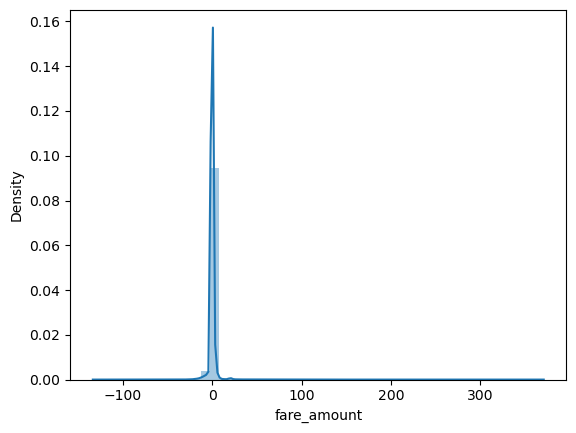

In [438]:
sns.distplot(Y_test - Y_pred)

Text(0, 0.5, 'Predicted')

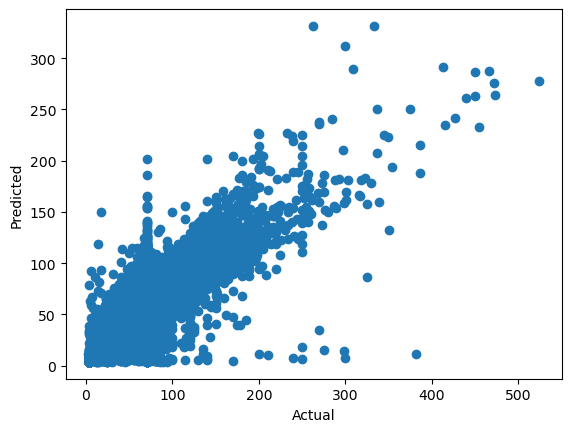

In [439]:
plt.scatter(Y_test,Y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='fare_amount'>

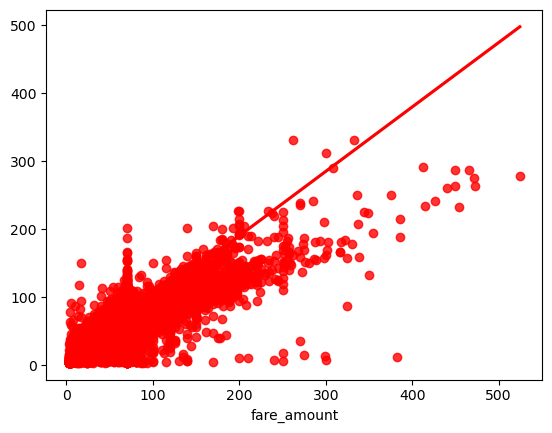

In [467]:
sns.regplot(x=Y_test,y=Y_pred,ci=None,color ='red')

In [468]:
pred_df=pd.DataFrame({'Actual Value':Y_test,'Predicted Value':Y_pred,'Difference':Y_test-Y_pred})
pred_df

,Actual Value,Predicted Value,Difference
2655202,7.9,8.468662,-0.568662
2890478,12.1,13.276158,-1.176158
1577621,13.5,13.686604,-0.186604
2188079,7.9,8.253504,-0.353504
403530,14.9,16.064312,-1.164312
...,...,...,...
1999484,35.2,34.486607,0.713393
1023482,12.8,13.236767,-0.436767
2570408,7.2,7.409734,-0.209734
1419995,7.9,7.424452,0.475548


### Significance Testing

In [469]:
X = sm.add_constant(X_test) # add a constant term to the feature matrix
model = sm.OLS(Y_pred, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.016e+33
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:32:21   Log-Likelihood:             2.5309e+07
No. Observations:              881032   AIC:                        -5.062e+07
Df Residuals:                  881022   BIC:                        -5.062e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.94

Bottom of the summary suggests that there might be strong multicollinearity problems or the design matrix may be singular, which can affect the reliability of the model's results.

## 2. Do you think this analysis can inform policymaking? If so, in which way?

Yes, I believe this analysis definitely inform policy making by identifying factors that contribute to higher taxi fares, which could help policy makers design policies to regulate fares and improve affordability. 
Findings 1:
There is strong correlation between fare amount and trip distance. This shows that longer trips usually cost more. Policy makers can consider measures such as encouraging public transportation for shorter trips and promoting ride sharing for longer trips to reduce congestion.
Findings 2:
There is significant change in the trip duration. So policy makers can promote long duration trips.
Findings 3:
In this analysis there is impact on the time of the day and on fares, policymakers could consider implementing surge pricing during peak hours to reduce congestion and encourage workers to work during off-peak hours. 
Findings 4:
I am sure that there is strong relationship between the pickup and drop-off location, but I have to decode those burogh codes to get more insights.

### Simulating Policy Scenarios

I want to check the fare amount during peak hours, so that policy can increase the supply of taxis during peak hours. This will help the policy makers to design policies that are likely to improve affordability without significantly impacting the revenue of taxi operators in NYC.

In [509]:
# Save Model To a File Using Python Pickle
import pickle
with open('model_pickle','wb') as file:
    pickle.dump(model,file)

In [510]:
#Load saved model
with open('model_pickle','rb') as file:
    mp = pickle.load(file)

#### Peak hour fair?

In [511]:
new_data = pd.DataFrame({
    'const':[1],
    'passenger_count':[1],
    'trip_distance':[3.5],
    'PULocationID':[195],
    'DOLocationID':[212],
    'trip_duration':[25],
    'time_of_day_afternoon':[0],
    'time_of_day_evening':[0],
    'time_of_day_morning':[1],
    'time_of_day_night':[0],
    'day_category_weekday':[1],
    'day_category_weekend':[0]
})

In [512]:
# make the prediction
fare_prediction = mp.predict(new_data)
print(f"${fare_prediction[0]:.2f}")

$22.03


#### Off-peak hour fair?

In [513]:
new_data = pd.DataFrame({
    'const':[1],
    'passenger_count':[1],
    'trip_distance':[3.5],
    'PULocationID':[195],
    'DOLocationID':[212],
    'trip_duration':[25],
    'time_of_day_afternoon':[0],
    'time_of_day_evening':[0],
    'time_of_day_morning':[0],
    'time_of_day_night':[1],
    'day_category_weekday':[1],
    'day_category_weekend':[0]
})

In [514]:
# make the prediction
fare_prediction = mp.predict(new_data)
print(f"${fare_prediction[0]:.2f}")

$21.72


##### Long trip fair?

In [515]:
new_data = pd.DataFrame({
    'const':[1],
    'passenger_count':[1],
    'trip_distance':[10.5],
    'PULocationID':[195],
    'DOLocationID':[212],
    'trip_duration':[25],
    'time_of_day_afternoon':[0],
    'time_of_day_evening':[0],
    'time_of_day_morning':[0],
    'time_of_day_night':[1],
    'day_category_weekday':[1],
    'day_category_weekend':[0]
})

In [516]:
# make the prediction
fare_prediction = mp.predict(new_data)
print(f"${fare_prediction[0]:.2f}")

$43.18


##### Short trip fair?

In [517]:
new_data = pd.DataFrame({
    'const':[1],
    'passenger_count':[1],
    'trip_distance':[2.5],
    'PULocationID':[195],
    'DOLocationID':[212],
    'trip_duration':[25],
    'time_of_day_afternoon':[0],
    'time_of_day_evening':[0],
    'time_of_day_morning':[0],
    'time_of_day_night':[1],
    'day_category_weekday':[1],
    'day_category_weekend':[0]
})

In [518]:
# make the prediction
fare_prediction = mp.predict(new_data)
print(f"${fare_prediction[0]:.2f}")

$18.66


##### Long duration fair?

In [519]:
new_data = pd.DataFrame({
    'const':[1],
    'passenger_count':[1],
    'trip_distance':[2.5],
    'PULocationID':[195],
    'DOLocationID':[212],
    'trip_duration':[100],
    'time_of_day_afternoon':[0],
    'time_of_day_evening':[0],
    'time_of_day_morning':[0],
    'time_of_day_night':[1],
    'day_category_weekday':[1],
    'day_category_weekend':[0]
})

In [520]:
# make the prediction
fare_prediction = mp.predict(new_data)
print(f"${fare_prediction[0]:.2f}")

$41.88


##### Short trip duration fair?

In [521]:
new_data = pd.DataFrame({
    'const':[1],
    'passenger_count':[1],
    'trip_distance':[2.5],
    'PULocationID':[195],
    'DOLocationID':[212],
    'trip_duration':[10],
    'time_of_day_afternoon':[0],
    'time_of_day_evening':[0],
    'time_of_day_morning':[0],
    'time_of_day_night':[1],
    'day_category_weekday':[1],
    'day_category_weekend':[0]
})

In [522]:
# make the prediction
fare_prediction = mp.predict(new_data)
print(f"${fare_prediction[0]:.2f}")

$14.02


## 3. What, if any, are your concerns with the data in hand? What other data could be useful for your analysis?

One concern with the data is that this is a representation of taxi trips that are paid electronically, which may not be the representative of all taxi trips in NYC. Also the data may be subjected to reporting errors or biases, such as drivers not reporting all of their trips or over reporting the fare amount. To address these concerns surveys or ride-hailing data could be used to validate the findings.

## 4. If you had more time, what would you have added to your analysis?

If I had more time, I would perform a cluster analysis to identify diffrent types of taxi trips based on their characteristics, such as distance, time of day and passenger count. This could provide insights into different market segments and help inform policy making for targeted interventions. Additionally, I would analyze external factors like weather and events on taxi fares. I also want to investigate the relationship between taxi fares and other modes of transportation like Uber/Lyft(ride-hailing) or public transit.